In [1]:
import tensorflow as tf
import glob
import matplotlib.image as mpimg
import keras
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
from keras import backend as K
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive
drive.mount('/content/drive')
my_path = '/content/drive/My Drive/Petfinding/Model Implementation'
# my_path = '/content/drive/My Drive/DS高级/Model Implementation'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
sample_path = my_path + '/sample'

In [5]:
class preprocessing():

  def __init__(self, path):
    self.path = path
  
  def read_all_file(self):
    # if type_ != '.jpg' and type_ != '.png':
    #   raise Exception("Sorry, we need files of image in .jpg or .png")

    txtfiles = []
    address = self.path + '/*' + '.jpg'
    for file in glob.glob(address):
      txtfiles.append(file)
    return txtfiles
  

  def get_petID(self):
    '''
    Input (list of string): filename with format: e.g. For 0fa6ba30b-1.jpg, 0fa6ba30b is the pet ID,  '1' is the number of image of given pet.

    Output: (list of string): list of PetIDs(labels)    
    '''
    txtfiles = self.read_all_file()
    names = [x.split('/')[-1].split('-')[0] for x in txtfiles]
    return names


  def get_image_name(self):
    '''
    Input (list of string): file path

    Output: (list of string): list of image names (labels)  e.g. 0fa6ba30b-1  
    '''
    txtfiles = self.read_all_file()
    image_path = [x.split('/')[-1].split('.')[0] for x in txtfiles]
    return image_path



 

    



In [6]:
def train_triplet_generator(df, batch_size=128, img_size=(96, 96)):
    """ training set triplet images generator """
    idxs = list(range(len(df)))
    labels = np.zeros((batch_size, 3, 1), dtype=K.floatx())
    
    while True:
        np.random.shuffle(idxs)
        anchor_img_path = []
        positive_img_path = []
        negative_img_path = []

        # get the image path list for all images
        for i in range(len(idxs)):
            # get anchor and positive images
            pair_path_list = df.loc[idxs[i], 'paths']
            count = df.loc[idxs[i], 'count']
            idx1, idx2 = np.random.randint(low=0, high=count, size=2)
            anchor = pair_path_list[idx1]
            positive = pair_path_list[idx2]
            
            # get negative images
            if i == len(idxs) - 1:
                neg_idx = idxs[0]
            else:
                neg_idx = idxs[i + 1]
            neg_path_list = df.loc[neg_idx, 'paths']
            neg_count = df.loc[neg_idx, 'count']
            idx3 = np.random.randint(low=0, high=neg_count, size=1)[0]
            negative = neg_path_list[idx3]

            anchor_img_path.append(anchor)
            positive_img_path.append(positive)
            negative_img_path.append(negative)

        # generate batch images
        for j in range(len(anchor_img_path) // batch_size):
            batch_anchor_img_path = anchor_img_path[j*batch_size : (j + 1)*batch_size]
            batch_positive_img_path = positive_img_path[j*batch_size : (j + 1)*batch_size]
            batch_negative_img_path = negative_img_path[j*batch_size : (j + 1)*batch_size]

            anchor_imgs = []
            positive_imgs = []
            negative_imgs = []

            # iteratively read images
            for k in range(batch_size):
                tmp_anc_img = load_img(batch_anchor_img_path[k], target_size=img_size)
                anchor_imgs.append(img_to_array(tmp_anc_img))

                tmp_pos_img = load_img(batch_positive_img_path[k], target_size=img_size)
                positive_imgs.append(img_to_array(tmp_pos_img))

                tmp_neg_img = load_img(batch_negative_img_path[k], target_size=img_size)
                negative_imgs.append(img_to_array(tmp_neg_img))

            # transform image list into array
            anc_imgs = np.array(anchor_imgs, dtype=K.floatx()) / 255.0
            pos_imgs = np.array(positive_imgs, dtype=K.floatx()) / 255.0
            neg_imgs = np.array(negative_imgs, dtype=K.floatx()) / 255.0

            yield [anc_imgs, pos_imgs, neg_imgs], labels

In [7]:
def path_to_list(df):
    """ function to merge df into the name and path list format """
    paths = list(df['path'].values)
    count = len(paths)
    
    return pd.Series([count, paths], index=['count', 'paths'])

In [8]:
import  warnings
warnings.simplefilter('ignore')

import numpy as np
from keras.layers import Dense, ZeroPadding2D, Activation
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Input, Lambda, Flatten, concatenate
from keras.layers import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf


In [9]:
a = preprocessing(sample_path)

In [10]:
import pandas as pd


In [11]:
df = pd.DataFrame(zip(a.get_petID(), a.read_all_file()), columns= ['name', 'path'])    

In [12]:
df.head(5)

,name,path
0,00f997463,/content/drive/My Drive/Petfinding/Model Imple...
1,00f997463,/content/drive/My Drive/Petfinding/Model Imple...
2,00f997463,/content/drive/My Drive/Petfinding/Model Imple...
3,0a0e8c15b,/content/drive/My Drive/Petfinding/Model Imple...
4,0a0e8c15b,/content/drive/My Drive/Petfinding/Model Imple...


In [13]:
def path_to_list(df):
    """ function to merge df into the name and path list format """
    paths = list(df['path'].values)
    count = len(paths)
    
    return pd.Series([count, paths], index=['count', 'paths'])

In [14]:
def groupby_df(df):
  sample_df = df.groupby('name').apply(path_to_list).reset_index()
  return sample_df

In [15]:
def train_test_split(sample_df):
  train_idx = np.random.randint(len(sample_df), size=int(len(sample_df) * 0.7), dtype = int)
  train_df = sample_df.iloc[train_idx].reset_index(drop = True)
  test_df = sample_df.iloc[~train_idx].reset_index(drop = True)
  return train_df, test_df

In [16]:
sample_df = df.groupby('name').apply(path_to_list).reset_index()
# vgg2_test_df = vgg2_test.groupby('name').apply(path_to_list).reset_index()

sample_df.head()

,name,count,paths
0,000a290e4,2,[/content/drive/My Drive/Petfinding/Model Impl...
1,000fb9572,3,[/content/drive/My Drive/Petfinding/Model Impl...
2,001a1aaad,4,[/content/drive/My Drive/Petfinding/Model Impl...
3,001b1507c,2,[/content/drive/My Drive/Petfinding/Model Impl...
4,00a1a8af4,3,[/content/drive/My Drive/Petfinding/Model Impl...


In [17]:
# train_idx = np.random.randint(len(sample_df), size=int(len(sample_df) * 0.7), dtype = int)
# train_df = sample_df.iloc[train_idx].reset_index(drop = True)
# test_df = sample_df.iloc[~train_idx].reset_index(drop = True)
import random
random.seed(30)

arr = np.arange(len(sample_df))
np.random.shuffle(arr)
arr_train = arr[:int(len(arr) * 0.7)]
arr_test = arr[int(len(arr) * 0.7):]
train_df = sample_df.iloc[arr_train].reset_index(drop = True)
test_df = sample_df.iloc[arr_test].reset_index(drop = True)

In [18]:
def train_triplet_generator(df, batch_size=32, img_size=(224, 224)):
    """ training set triplet images generator """
    idxs = list(range(len(df)))
    labels = np.zeros((batch_size, 3, 1), dtype=K.floatx())
    
    while True:
        np.random.shuffle(idxs)
        anchor_img_path = []
        positive_img_path = []
        negative_img_path = []

        # get the image path list for all images
        for i in range(len(idxs)):
            # get anchor and positive images
            pair_path_list = df.loc[idxs[i], 'paths']
            count = df.loc[idxs[i], 'count']
            idx1, idx2 = np.random.randint(low=0, high=count, size=2)
            anchor = pair_path_list[idx1]
            positive = pair_path_list[idx2]
            
            # get negative images
            if i == len(idxs) - 1:
                neg_idx = idxs[0]
            else:
                neg_idx = idxs[i + 1]
            neg_path_list = df.loc[neg_idx, 'paths']
            neg_count = df.loc[neg_idx, 'count']
            idx3 = np.random.randint(low=0, high=neg_count, size=1)[0]
            negative = neg_path_list[idx3]

            anchor_img_path.append(anchor)
            positive_img_path.append(positive)
            negative_img_path.append(negative)

        # generate batch images
        for j in range(len(anchor_img_path) // batch_size):
            batch_anchor_img_path = anchor_img_path[j*batch_size : (j + 1)*batch_size]
            batch_positive_img_path = positive_img_path[j*batch_size : (j + 1)*batch_size]
            batch_negative_img_path = negative_img_path[j*batch_size : (j + 1)*batch_size]

            anchor_imgs = []
            positive_imgs = []
            negative_imgs = []

            # iteratively read images
            for k in range(batch_size):
                tmp_anc_img = load_img(batch_anchor_img_path[k], target_size=img_size)
                anchor_imgs.append(img_to_array(tmp_anc_img))

                tmp_pos_img = load_img(batch_positive_img_path[k], target_size=img_size)
                positive_imgs.append(img_to_array(tmp_pos_img))

                tmp_neg_img = load_img(batch_negative_img_path[k], target_size=img_size)
                negative_imgs.append(img_to_array(tmp_neg_img))

            # transform image list into array
            anc_imgs = np.array(anchor_imgs, dtype=K.floatx()) / 255.0
            pos_imgs = np.array(positive_imgs, dtype=K.floatx()) / 255.0
            neg_imgs = np.array(negative_imgs, dtype=K.floatx()) / 255.0

            yield [anc_imgs, pos_imgs, neg_imgs], labels



def test_triplet_generator(df, batch_size=32, loops=2, img_size=(224, 224), seed=42):
    """ test set triplet images generator, it will generate 1000 pairs """
    idxs = list(range(len(df)))
    labels = np.zeros((batch_size, 3, 1), dtype=K.floatx())

    while True:
        np.random.seed(seed)
        np.random.shuffle(idxs)
        anchor_img_path = []
        positive_img_path = []
        negative_img_path = []

        # get the image path list for all images
        for outer in range(loops):
            for i in range(len(idxs)):
                # get anchor and positive images
                pair_path_list = df.loc[idxs[i], 'paths']
                count = df.loc[idxs[i], 'count']
                idx1, idx2 = np.random.randint(low=0, high=count, size=2)
                anchor = pair_path_list[idx1]
                positive = pair_path_list[idx2]
                
                # get negative images
                if i == len(idxs) - 1:
                    neg_idx = idxs[0]
                else:
                    neg_idx = idxs[i + 1]
                neg_path_list = df.loc[neg_idx, 'paths']
                neg_count = df.loc[neg_idx, 'count']
                idx3 = np.random.randint(low=0, high=neg_count, size=1)[0]
                negative = neg_path_list[idx3]

                anchor_img_path.append(anchor)
                positive_img_path.append(positive)
                negative_img_path.append(negative)
                    
        # generate batch images
        for j in range(len(anchor_img_path) // batch_size):
            batch_anchor_img_path = anchor_img_path[j*batch_size : (j + 1)*batch_size]
            batch_positive_img_path = positive_img_path[j*batch_size : (j + 1)*batch_size]
            batch_negative_img_path = negative_img_path[j*batch_size : (j + 1)*batch_size]

            anchor_imgs = []
            positive_imgs = []
            negative_imgs = []

            # iteratively read images
            for k in range(batch_size):
                tmp_anc_img = load_img(batch_anchor_img_path[k], target_size=img_size)
                anchor_imgs.append(img_to_array(tmp_anc_img))

                tmp_pos_img = load_img(batch_positive_img_path[k], target_size=img_size)
                positive_imgs.append(img_to_array(tmp_pos_img))

                tmp_neg_img = load_img(batch_negative_img_path[k], target_size=img_size)
                negative_imgs.append(img_to_array(tmp_neg_img))

            # transform image list into array
            anc_imgs = np.array(anchor_imgs, dtype=K.floatx()) / 255.0
            pos_imgs = np.array(positive_imgs, dtype=K.floatx()) / 255.0
            neg_imgs = np.array(negative_imgs, dtype=K.floatx()) / 255.0

            yield [anc_imgs, pos_imgs, neg_imgs], labels



In [19]:

def triplet_net(base_model, input_shape=(224, 224, 3)):
    """ define triplet networks """
    # define input: anchor, positive, negative images
    anchor = Input(shape=input_shape, name='anchor_input')
    positive = Input(shape=input_shape, name='positive_input')
    negative = Input(shape=input_shape, name='negative_input')

    # extract vector represent using CNN base model
    anc_vec = base_model(anchor)
    pos_vec = base_model(positive)
    neg_vec = base_model(negative)

    # stack outputs
    stacks = Lambda(lambda x: K.stack(x, axis=1), name='output')([anc_vec, pos_vec, neg_vec])

    # define inputs and outputs
    inputs=[anchor, positive, negative]
    outputs = stacks

    # define the triplet model
    model = Model(inputs=inputs, outputs=outputs, name='triplet_net')

    return model


def triplet_loss(margin=0.2):
    """ wrapper function for triplet loss """
    def loss(y_true, y_pred):
        """ function to calculate the triplet loss"""
        # define zero constant
        zero = K.constant(0.0)

        # get the prediction vector
        anchor, positive, negative = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]

        # compute distance
        pos_distance = K.sum(K.square(anchor - positive), axis=1)
        neg_distance = K.sum(K.square(anchor - negative), axis=1)

        # compute loss
        partial_loss = pos_distance - neg_distance + margin
        full_loss = K.sum(K.maximum(partial_loss, zero), axis=0)

        return full_loss
    return loss





# -----------------------------------------------------------------------------------
# The following code is modified from https://github.com/iwantooxxoox/Keras-OpenFace
# -----------------------------------------------------------------------------------

def LRN2D(x):
    """ local response normalization """
    lrn = tf.nn.local_response_normalization(x, alpha=1e-4, beta=0.75)
    return lrn


def conv2d_bn(x, layer=None, cv1_out=None, cv1_filter=(1, 1), cv1_strides=(1, 1),
              cv2_out=None, cv2_filter=(3, 3), cv2_strides=(1, 1), padding=None):
    """ 2D convolution with batch normalization """
    if cv2_out is None:
        num = ''
    else:
        num = '1'

    tensor = Conv2D(cv1_out, cv1_filter, strides=cv1_strides, name=layer+'_conv'+num)(x)
    tensor = BatchNormalization(axis=3, epsilon=0.00001, name=layer+'_bn'+num)(tensor)
    tensor = Activation('relu')(tensor)

    if padding is None:
        return tensor

    tensor = ZeroPadding2D(padding=padding)(tensor)
    if cv2_out is None:
        return tensor

    tensor = Conv2D(cv2_out, cv2_filter, strides=cv2_strides, name=layer+'_conv2')(tensor)
    tensor = BatchNormalization(axis=3, epsilon=0.00001, name=layer+'_bn2')(tensor)
    tensor = Activation('relu')(tensor)

    return tensor


def basenet(output_shape=128):
    """ create base-net for face verification """
    input_shape = (96, 96, 3)
    inputs = Input(shape=input_shape, name='input')

    # convolution layers
    x = ZeroPadding2D(padding=(3, 3), input_shape=input_shape)(inputs)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn1')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)
    x = Lambda(LRN2D, name='lrn_1')(x)
    x = Conv2D(64, (1, 1), name='conv2')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn2')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(192, (3, 3), name='conv3')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn3')(x)
    x = Activation('relu')(x)
    x = Lambda(LRN2D, name='lrn_2')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)

    # inception_3a
    inception_3a_3x3 = Conv2D(96, (1, 1), name='inception_3a_3x3_conv1')(x)
    inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn1')(inception_3a_3x3)
    inception_3a_3x3 = Activation('relu')(inception_3a_3x3)
    inception_3a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3a_3x3)
    inception_3a_3x3 = Conv2D(128, (3, 3), name='inception_3a_3x3_conv2')(inception_3a_3x3)
    inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn2')(inception_3a_3x3)
    inception_3a_3x3 = Activation('relu')(inception_3a_3x3)

    inception_3a_5x5 = Conv2D(16, (1, 1), name='inception_3a_5x5_conv1')(x)
    inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn1')(inception_3a_5x5)
    inception_3a_5x5 = Activation('relu')(inception_3a_5x5)
    inception_3a_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3a_5x5)
    inception_3a_5x5 = Conv2D(32, (5, 5), name='inception_3a_5x5_conv2')(inception_3a_5x5)
    inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn2')(inception_3a_5x5)
    inception_3a_5x5 = Activation('relu')(inception_3a_5x5)

    inception_3a_pool = MaxPooling2D(pool_size=3, strides=2)(x)
    inception_3a_pool = Conv2D(32, (1, 1), name='inception_3a_pool_conv')(inception_3a_pool)
    inception_3a_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_pool_bn')(inception_3a_pool)
    inception_3a_pool = Activation('relu')(inception_3a_pool)
    inception_3a_pool = ZeroPadding2D(padding=((3, 4), (3, 4)))(inception_3a_pool)

    inception_3a_1x1 = Conv2D(64, (1, 1), name='inception_3a_1x1_conv')(x)
    inception_3a_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_1x1_bn')(inception_3a_1x1)
    inception_3a_1x1 = Activation('relu')(inception_3a_1x1)

    inception_3a = concatenate([inception_3a_3x3, inception_3a_5x5, inception_3a_pool, inception_3a_1x1], axis=3)

    # inception_3b
    inception_3b_3x3 = Conv2D(96, (1, 1), name='inception_3b_3x3_conv1')(inception_3a)
    inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn1')(inception_3b_3x3)
    inception_3b_3x3 = Activation('relu')(inception_3b_3x3)
    inception_3b_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3b_3x3)
    inception_3b_3x3 = Conv2D(128, (3, 3), name='inception_3b_3x3_conv2')(inception_3b_3x3)
    inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn2')(inception_3b_3x3)
    inception_3b_3x3 = Activation('relu')(inception_3b_3x3)

    inception_3b_5x5 = Conv2D(32, (1, 1), name='inception_3b_5x5_conv1')(inception_3a)
    inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn1')(inception_3b_5x5)
    inception_3b_5x5 = Activation('relu')(inception_3b_5x5)
    inception_3b_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3b_5x5)
    inception_3b_5x5 = Conv2D(64, (5, 5), name='inception_3b_5x5_conv2')(inception_3b_5x5)
    inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn2')(inception_3b_5x5)
    inception_3b_5x5 = Activation('relu')(inception_3b_5x5)

    inception_3b_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3a)
    inception_3b_pool = Conv2D(64, (1, 1), name='inception_3b_pool_conv')(inception_3b_pool)
    inception_3b_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_pool_bn')(inception_3b_pool)
    inception_3b_pool = Activation('relu')(inception_3b_pool)
    inception_3b_pool = ZeroPadding2D(padding=(4, 4))(inception_3b_pool)

    inception_3b_1x1 = Conv2D(64, (1, 1), name='inception_3b_1x1_conv')(inception_3a)
    inception_3b_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_1x1_bn')(inception_3b_1x1)
    inception_3b_1x1 = Activation('relu')(inception_3b_1x1)

    inception_3b = concatenate([inception_3b_3x3, inception_3b_5x5, inception_3b_pool, inception_3b_1x1], axis=3)

    # inception_3c
    inception_3c_3x3 = conv2d_bn(inception_3b, layer='inception_3c_3x3', cv1_out=128, cv1_filter=(1, 1),
                                 cv2_out=256, cv2_filter=(3, 3), cv2_strides=(2, 2), padding=(1, 1))

    inception_3c_5x5 = conv2d_bn(inception_3b, layer='inception_3c_5x5', cv1_out=32, cv1_filter=(1, 1),
                                 cv2_out=64, cv2_filter=(5, 5), cv2_strides=(2, 2), padding=(2, 2))

    inception_3c_pool = MaxPooling2D(pool_size=3, strides=2)(inception_3b)
    inception_3c_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_3c_pool)

    inception_3c = concatenate([inception_3c_3x3, inception_3c_5x5, inception_3c_pool], axis=3)

    # inception_4a
    inception_4a_3x3 = conv2d_bn(inception_3c, layer='inception_4a_3x3', cv1_out=96, cv1_filter=(1, 1),
                                 cv2_out=192, cv2_filter=(3, 3), cv2_strides=(1, 1), padding=(1, 1))

    inception_4a_5x5 = conv2d_bn(inception_3c, layer='inception_4a_5x5', cv1_out=32, cv1_filter=(1, 1),
                                 cv2_out=64, cv2_filter=(5, 5), cv2_strides=(1, 1), padding=(2, 2))

    inception_4a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3c)
    inception_4a_pool = conv2d_bn(inception_4a_pool, layer='inception_4a_pool', cv1_out=128,
                                  cv1_filter=(1, 1), padding=(2, 2))

    inception_4a_1x1 = conv2d_bn(inception_3c, layer='inception_4a_1x1', cv1_out=256, cv1_filter=(1, 1))

    inception_4a = concatenate([inception_4a_3x3, inception_4a_5x5, inception_4a_pool, inception_4a_1x1], axis=3)

    # inception_4b
    inception_4b_3x3 = conv2d_bn(inception_4a, layer='inception_4b_3x3', cv1_out=160, cv1_filter=(1, 1),
                                 cv2_out=256, cv2_filter=(3, 3), cv2_strides=(2, 2), padding=(1, 1))

    inception_4b_5x5 = conv2d_bn(inception_4a, layer='inception_4b_5x5', cv1_out=64, cv1_filter=(1, 1),
                                 cv2_out=128, cv2_filter=(5, 5), cv2_strides=(2, 2), padding=(2, 2))

    inception_4b_pool = MaxPooling2D(pool_size=3, strides=2)(inception_4a)
    inception_4b_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_4b_pool)

    inception_4b = concatenate([inception_4b_3x3, inception_4b_5x5, inception_4b_pool], axis=3)

    # inception_5a
    inception_5a_3x3 = conv2d_bn(inception_4b, layer='inception_5a_3x3', cv1_out=96, cv1_filter=(1, 1),
                                 cv2_out=384, cv2_filter=(3, 3), cv2_strides=(1, 1), padding=(1, 1))

    inception_5a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_4b)
    inception_5a_pool = conv2d_bn(inception_5a_pool, layer='inception_5a_pool', cv1_out=96,
                                  cv1_filter=(1, 1), padding=(1, 1))

    inception_5a_1x1 = conv2d_bn(inception_4b, layer='inception_5a_1x1', cv1_out=256, cv1_filter=(1, 1))

    inception_5a = concatenate([inception_5a_3x3, inception_5a_pool, inception_5a_1x1], axis=3)

    # inception_5b
    inception_5b_3x3 = conv2d_bn(inception_5a, layer='inception_5b_3x3', cv1_out=96, cv1_filter=(1, 1),
                                 cv2_out=384, cv2_filter=(3, 3), cv2_strides=(1, 1), padding=(1, 1))

    inception_5b_pool = MaxPooling2D(pool_size=3, strides=2)(inception_5a)
    inception_5b_pool = conv2d_bn(inception_5b_pool, layer='inception_5b_pool', cv1_out=96, cv1_filter=(1, 1))
    inception_5b_pool = ZeroPadding2D(padding=(1, 1))(inception_5b_pool)

    inception_5b_1x1 = conv2d_bn(inception_5a, layer='inception_5b_1x1', cv1_out=256, cv1_filter=(1, 1))

    inception_5b = concatenate([inception_5b_3x3, inception_5b_pool, inception_5b_1x1], axis=3)

    # final output layers
    av_pool = AveragePooling2D(pool_size=(3, 3), strides=(1, 1))(inception_5b)
    reshape_layer = Flatten()(av_pool)
    dense_layer = Dense(output_shape, name='dense_layer')(reshape_layer)
    norm_layer = Lambda(lambda x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)

    return Model(inputs=inputs, outputs=norm_layer)


In [20]:
# create the base pre-trained model
from tensorflow.keras.applications.vgg16 import VGG16
base_model = VGG16(weights='imagenet')


In [21]:
import os

In [22]:
import random
# For reproduciable purpose
seed = 42
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.random.set_seed(seed)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess);


In [23]:
from keras.utils import plot_model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau


In [24]:
# base_model = basenet(output_shape=128)
# plot_model(base_model, show_shapes=True, show_layer_names = True)

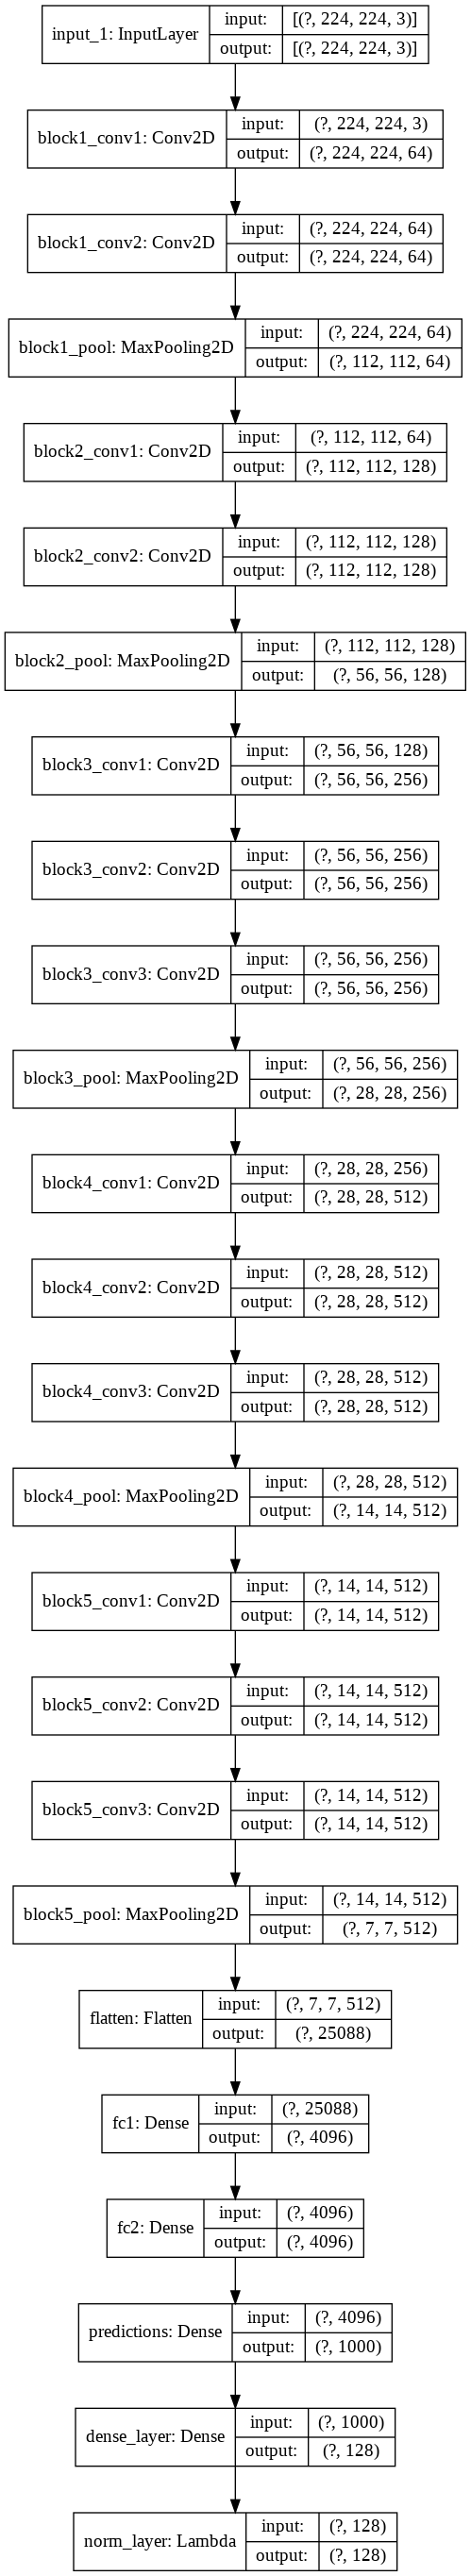

In [25]:
# base_model = basenet(output_shape=128)


# base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer

output_shape=128

from tensorflow.keras.applications.vgg16 import VGG16
base_model = VGG16(weights='imagenet')

x = base_model.output
dense_layer = Dense(output_shape, name='dense_layer')(x)
norm_layer = Lambda(lambda x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)


model_1 = Model(inputs=base_model.input, outputs=norm_layer)


plot_model(model_1, show_shapes=True, show_layer_names = True)

In [26]:
for layer in base_model.layers:
    layer.trainable = False

triplet_model = triplet_net(base_model=model_1, input_shape=(224, 224, 3))
triplet_model.summary()


Model: "triplet_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 128)          138485672   anchor_input[0][0]               
                                                                 positive_input[0][0]   

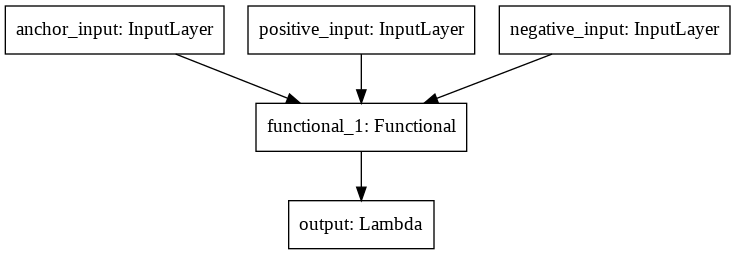

In [27]:
plot_model(triplet_model)

### Triplet Loss

In [28]:
def lr_schedule(epoch):
    """ Learning rate schedule """
    lr = 1e-4
    if epoch >= 900:
        lr *= 1e-1
    elif epoch >= 800:
        lr *= 2e-1
    elif epoch >= 700:
        lr *= 3e-1
    elif epoch >= 600:
        lr *= 4e-1
    elif epoch >= 500:
        lr *= 5e-1
    elif epoch >= 400:
        lr *= 6e-1
    elif epoch >= 300:
        lr *= 7e-1
    elif epoch >= 200:
        lr *= 8e-1
    elif epoch >= 100:
        lr *= 9e-1
        
    return lr

In [29]:

# define optimizer

opt = keras.optimizers.Adam(lr=lr_schedule(0))

# create checkpoint folder
path = sample_path + time.strftime('%Y%m%d-%H%M')
if not os.path.exists(path):
    os.mkdir(path)
print('Checkpoing Folder:\t', path)    

# create call backs
checkpoint = ModelCheckpoint(filepath=path + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                             monitor='val_loss', verbose=0, save_best_only=False, 
                             save_weights_only=False, mode='auto', period=10)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# compile the model
triplet_model.compile(optimizer=opt, loss=triplet_loss(0.1))

# define training and test dataset image generator
train_generator = train_triplet_generator(train_df, batch_size=128)
test_generator = test_triplet_generator(test_df, batch_size=100, loops=10, seed=42)

Checkpoing Folder:	 /content/drive/My Drive/Petfinding/Model Implementation/sample20201108-1737


### Fit Model


In [30]:
import pickle, gc

In [31]:
# fit the model

# history = triplet_model.fit_generator(train_generator, steps_per_epoch=67, epochs= 200, 
#                                       validation_data=test_generator, validation_steps=50, 
#                                       verbose=2, callbacks=callbacks)

# model_1.save(my_path + '/facenet-model.h5')
# pickle.dump(history.history, open(my_path + '/facenet-history.p', 'wb'))
# _ = gc.collect()

In [32]:
# import matplotlib.pyplot as plt

# train_loss = history.history['loss']
# val_loss = history.history['val_loss']

# fig, ax = plt.subplots(figsize=(10, 7))
# ax.plot(train_loss, label='Training Loss')
# ax.plot(val_loss, label='Validation Loss')
# ax.set_title('Loss vs. Epochs', fontsize=16)
# ax.set_xlabel('Epochs', fontsize=14)
# ax.set_ylabel('Loss', fontsize=14)
# ax.legend(fontsize=14)
# ax.grid(True)
# plt.tight_layout()
# plt.show()

### Model Prediction

In [33]:
### Ignore tensorflow warning 

import logging
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [34]:
from keras.models import load_model

class face_verify_predict(object):

    '''
    - This Class 
        - Predict the Siamese Embedding of two images
        - Calculate the distance between two embedded images
        - Verify whether two images comes from the same pet given threshold and calculated distance
        - Visualize the result

    '''

    def __init__(self, path):
        """ initialize the model path"""
        self.path = path
        self.model = None
        

    def _load_model(self):
        """ load the pre-defined cnn model for face verification """
        self.model = keras.models.load_model(self.path, custom_objects={'tf': tf})


    def preprocess_image(self, path):
        """ read and normalize the images """
        
        img = load_img(path, target_size=(224, 224))
        img = img_to_array(img) / 255.0

        return img

    def Siamese_embedding(self, path1, path2):
        '''
        Get the predicted Siamese embedding of two input paths of images

        - path1 (string): path for image 1
        - path2 (string): path for image 2
        - Output: (numpy array (matrix)): Siamese embedding for image 1 and 2

        '''
        
        if self.model is None:
            self._load_model()

       # pre-process the images

        img1 = self.preprocess_image(path1)
        img2 = self.preprocess_image(path2)

        imgs = np.array([img1, img2])
        predictions = self.model.predict(imgs)
        
        pred1, pred2 = predictions[0], predictions[1]

        return pred1, pred2


    def get_distance(self, path1, path2):
        """ 
        get the distance between two images from path1 and path2 
        
        """

        pred1, pred2 = self.Siamese_embedding(path1, path2)
        
        def Euclidean_distance(pred1, pred2):
            distance = np.sqrt(np.sum(np.square(pred1 - pred2)))
            return distance 

        return Euclidean_distance(pred1, pred2)


    def verify(self, path1, path2, threshold):
        """ verify whether or not images from path1 and path2 are same person """
        distance = self.get_distance(path1, path2)
        
        if distance <= threshold:
            return True

        return False
    

    def visualize_result(self, path1, path2):

        distance = self.get_distance(path1, path2)
        img1, img2 = load_img(path1, target_size=(128, 128)), load_img(path2, target_size=(128, 128))
        fig, ax = plt.subplots(nrows=1, ncols=2)
        plt.suptitle('The distance between two images is %1.3f' %distance, fontsize=14)
        ax[0].imshow(img1)
        ax[1].imshow(img2)
      


In [35]:
test_df.iloc[14]['paths']

['/content/drive/My Drive/Petfinding/Model Implementation/sample/0bf83cc3e-1.jpg',
 '/content/drive/My Drive/Petfinding/Model Implementation/sample/0bf83cc3e-2.jpg']

In [36]:
verification_model = face_verify_predict(my_path + '/facenet-model.h5')

In [37]:
path1_test = '/content/drive/My Drive/Petfinding/Model Implementation/sample/0a555d688-1.jpg'
path2_test = '/content/drive/My Drive/Petfinding/Model Implementation/sample/0a1b56e66-2.jpg'
verification_model.get_distance(path1_test, path2_test)

1.2462828

In [38]:
verification_model.verify(path1_test, path2_test, 1.0)

False

## Demo Visualization

### Show the distance which are from different pets

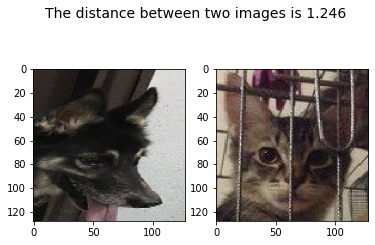

In [39]:
verification_model.visualize_result(path1_test, path2_test)

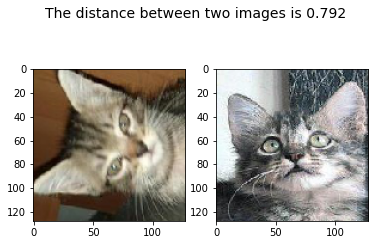

In [40]:
path3_test = '/content/drive/My Drive/Petfinding/Model Implementation/sample/0e783a2e1-1.jpg'
path4_test = '/content/drive/My Drive/Petfinding/Model Implementation/sample/0a7798d2b-10.jpg'

verification_model.visualize_result(path3_test, path4_test)

### Show the distance which are from the pet

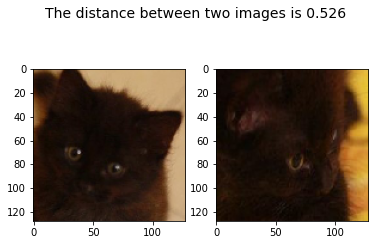

In [41]:
path7_test ='/content/drive/My Drive/Petfinding/Model Implementation/sample/0f0f81a37-1.jpg'
path8_test ='/content/drive/My Drive/Petfinding/Model Implementation/sample/0f0f81a37-2.jpg'
verification_model.visualize_result(path7_test, path8_test)

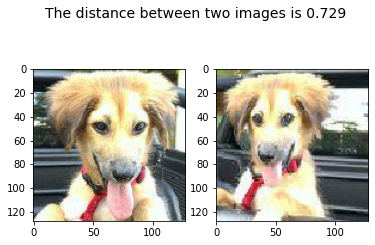

In [42]:
path9_test ='/content/drive/My Drive/Petfinding/Model Implementation/sample/0e9a2fed4-1.jpg'
path10_test ='/content/drive/My Drive/Petfinding/Model Implementation/sample/0e9a2fed4-2.jpg'
verification_model.visualize_result(path9_test, path10_test)

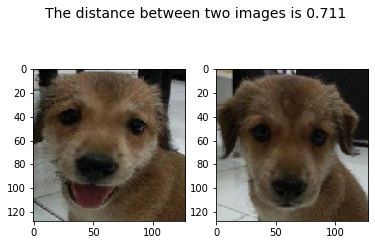

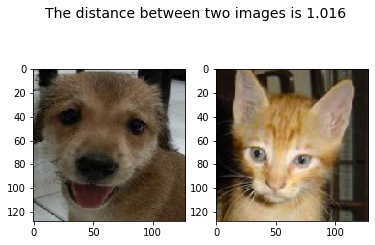

In [43]:
path_same1 = '/content/drive/My Drive/Petfinding/Model Implementation/sample/0d6cb5b69-1.jpg'
path_same2 = '/content/drive/My Drive/Petfinding/Model Implementation/sample/0d6cb5b69-3.jpg'
path_diff1 = '/content/drive/My Drive/Petfinding/Model Implementation/sample/0ce5d0b5f-1.jpg'
verification_model.visualize_result(path_same1, path_same2)
verification_model.visualize_result(path_same1, path_diff1)


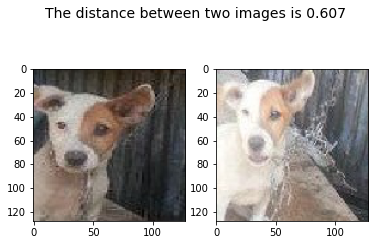

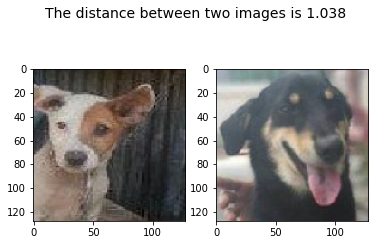

In [44]:
path_same1 = '/content/drive/My Drive/Petfinding/Model Implementation/sample/00c71a320-1.jpg'
path_same2 =  '/content/drive/My Drive/Petfinding/Model Implementation/sample/00c71a320-2.jpg'
path_diff1 = '/content/drive/My Drive/Petfinding/Model Implementation/sample/0b501f1d8-1.jpg'
verification_model.visualize_result(path_same1, path_same2)
verification_model.visualize_result(path_same1, path_diff1)

# Binary Classification Approach

- Defined Transferred Learning Model (VGG16)
  - Remove the last prediction layer
  - Replace by a Dense Layer and a Normalization Layer (output dimension 1000)

- Sample pairs (pair of image path)
  - Image from the same pet
  - Image from different pets
  
- Train-test Split (path)

- Define Embedding Dictionary 
  - key: image path
  - value: embedding matrix 

- Embed train and test data and concatenate pair of two images together

- Classification
  - Logistic Regression
  - xgBoost
  - Random Forest
  - SVM with Gaussian Kernel

- Evaluation

In [47]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

output_shape = 1000
feature_model = VGG16(weights='imagenet')
feature_model = Model(feature_model.input,feature_model.layers[-2].output)
x = feature_model.output
dense_layer = Dense(output_shape, name='dense_layer')(x)
norm_layer = Lambda(lambda x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)
feature_model = Model(inputs=feature_model.input, outputs=norm_layer)


# feature_model = Model(inputs=feature_model.input, outputs=feature_model.get_layer('flatten').output)
# x = feature_model.output
# dense_layer = Dense(output_shape, name='dense_layer')(x)
# norm_layer = Lambda(lambda x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)

# feature_model = Model(inputs=feature_model.input, outputs=norm_layer)


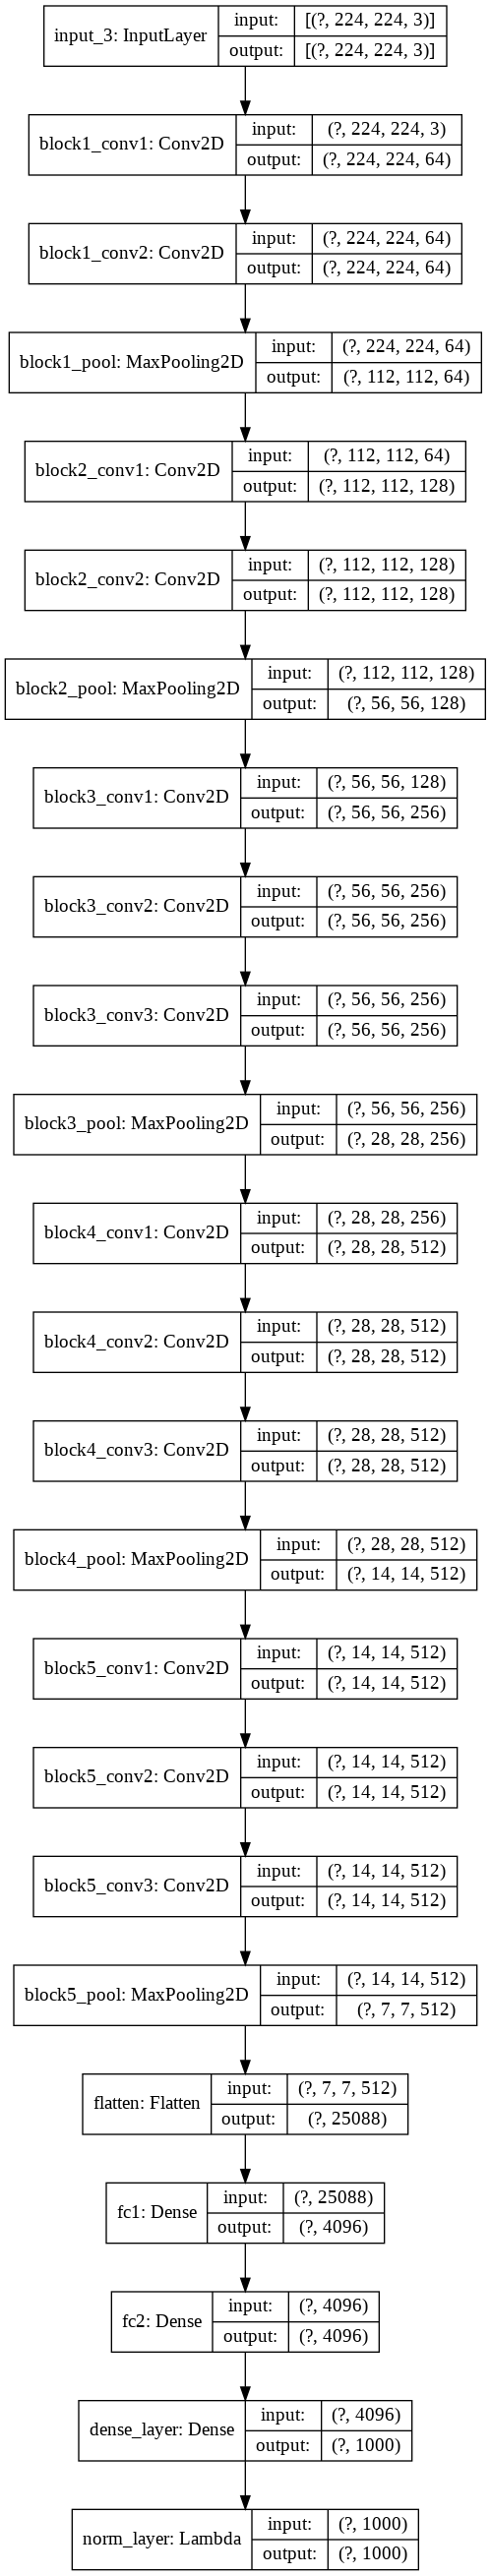

In [48]:
plot_model(feature_model, show_shapes=True, show_layer_names = True)

In [49]:
img_path = '/content/drive/My Drive/Petfinding/Model Implementation/sample/00f997463-7.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = feature_model.predict(x)

In [50]:
features.shape

(1, 1000)

In [51]:
def vgg_embedding(path):
  '''
  vgg_embedding: use pretrained vgg16 as a tool of feature engineering
  
  '''
  img = image.load_img(path, target_size= (224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)
  x = preprocess_input(x)
  features = feature_model.predict(x)

  return features


In [52]:
def embedding_map(all_path):
  '''
  Embedding maps: embed all images with VGG16
    - all_path(list of string): list of all images paths
    - output (dictionary of numpy array): embedding dictionary with image path as key and embeded matrix as value
  '''
  result = {}
  for path in all_path:
    result[path] = vgg_embedding(path)
  return result

### Sample Pairs

- For images from the same Pet:
    - Get all the combinations of pairs
    - Shuffle all pairs
    - Select top $\frac{k}{2}$ pairs
- For images from the different Pet:
  - Random Select two index
  - Given two index, get the random pair 
    - If this pair comes from the same PetId, or pair is duplicate, then resample a pair. (Step 1)
    - Repeat step 1, until condition fails





In [53]:
from itertools import combinations 

def generate_k_pairs(array, df, k):

  ### Generate paris from the same PetID
  sample = []
  for i in range(len(df)):
    tmp = df.loc[i, 'paths'] 
    combs = list(combinations(tmp, 2))
    sample += combs
  
  if len(sample) < k:
    print('Sample size is too large')
    return None

  else:
    np.random.shuffle(sample)
    sample = sample[: k//2]
    label_same = [0 for _ in range(len(sample))]


  ### Generate pairs from different petId
  result, label_list = [], []

  def random_pairs(array): 
    idx = random.sample(range(len(array)), 2)
    return idx

  idx = random_pairs(array)
  pair = (array[idx[0]], array[idx[1]])
  labels = [x.split('/')[-1].split('.')[0].split('-')[0] for x in pair]
  for i in range(k // 2):

    ### If the pair generator is in our sample or the PetIDs are the same, then resample a pair 

    while (pair in result) or (labels[0] == labels[1]):
      idx = random_pairs(array)
      pair = (array[idx[0]], array[idx[1]])
      labels = [x.split('/')[-1].split('.')[0].split('-')[0] for x in pair]

    result.append(pair)
    label_list.append(1)

  label_list = label_list + label_same
  result = result + sample

  return result, label_list



In [54]:
files = a.read_all_file()
samples, labels = generate_k_pairs(files, sample_df, 2000) 


In [55]:
image_map = embedding_map(files)

In [56]:
def test_unique_pairs(sample):
  if len(set(sample)) == len(sample):
    return True
  else:
    return False



In [57]:
### Test all sample pairs unique
test_unique_pairs(samples)

True

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size=0.3, random_state=42)

In [59]:
def test_samples(X, labels):
  names = [x.split('/')[-1].split('.')[0].split('-')[0] for x in X]

  assert (names[0] == names[1] and labels == 0) or (names[0] != names[1] and labels == 1)

In [60]:
for i in range(len(X_train)):
  test_samples(X_train[i], y_train[i])

In [61]:
def convert_to_train(image_map, X):
  
  result = []
  for x in X:
    embed0 = image_map[x[0]]
    embed1 = image_map[x[1]]
    embed = np.concatenate((embed0, embed1), axis=1)
    result.append(embed)
    
  result = np.stack(result, axis=0)
  result = np.array(result).reshape(len(X), -1)
  return result

In [62]:
train_value = convert_to_train(image_map, X_train)
test_value = convert_to_train(image_map, X_test)


### Fit Logistic Regression 

In [63]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs', penalty = 'l2', C = 10, n_jobs = -1, max_iter = 300)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(lr, train_value, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.587


In [64]:
from sklearn import metrics


pred = lr.fit(train_value, y_train).predict(test_value)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)

metrics.auc(fpr, tpr)

0.5669363082803681

### Fit xgboost

In [65]:
from xgboost import XGBClassifier


xgb = XGBClassifier(val_metric = 'auc', n_estimator = 200)

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(xgb, train_value, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.750


In [66]:


xgb = XGBClassifier(val_metric = 'auc', n_estimator = 200)

pred = xgb.fit(train_value, y_train).predict(test_value)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)

metrics.auc(fpr, tpr)

0.6734521534290413

### Fit Random Forest

In [67]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators = 200)


cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(rf, train_value, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.790


In [68]:

rf = RandomForestClassifier(n_estimators = 200)
pred = rf.fit(train_value, y_train).predict(test_value)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)

metrics.auc(fpr, tpr)

0.7199208853726833

### Fit SVM with Gaussian Kernel

In [70]:
from sklearn.svm import SVC

svc = SVC()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(svc, train_value, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.864


In [71]:

pred = svc.fit(train_value, y_train).predict(test_value)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)

metrics.auc(fpr, tpr)

0.766834081514734